In [1]:
!pip install japanize-matplotlib

In [2]:
import os
import zipfile
from glob import glob
from pathlib import Path
import math
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pylab as plab
from mpl_toolkits.mplot3d import Axes3D
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore')

from contextlib import contextmanager
from time import time

class Timer:
    """処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

#最大表示列数の指定
pd.set_option('display.max_columns', 50)
#最大表示行数の指定
pd.set_option('display.max_rows', 50)

def seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
seed(1)

In [3]:
# データの生成
from sklearn import datasets

dataType = 1
labels = ["がく長","がく幅","花びら長","花びら幅"]

iris = datasets.load_iris()
X = iris.data

In [4]:
class PCA:
    """PCA"""
    def __init__(self,X):
        """
        args:
            X: 
                入力データ（データ数×次元数のnumpy.ndarray）
        """
        # データの中心化
        self.mean = np.mean(X,axis=0)
        self.X = X - self.mean

    def reduceDim(self,lowerDim):
        """
        args:
            lowerDim: 
                低次元空間の次元数（整数スカラー）
        """
        self.lowerDim = lowerDim

        # 分散共分散行列
        cov = np.cov(self.X.T,bias=1)
        
        # 固有値問題
        L,V = np.linalg.eig(cov)
        
        # 固有値と固有ベクトルの固有値の降順でソート
        inds = np.argsort(L)[::-1]
        self.L = L[inds]
        self.W = V[:,inds]
        
        # 主成分得点の計算
        self.F = np.matmul(self.X,self.W[:,:lowerDim])

    def plotResult(self,xLabel="$z_1$",yLabel="$z_2$",fName=""):
        """
        次元削減後のデータ（主成分得点）のプロット
        args:
            xLabel: 
                x軸のラベル（文字列）
            yLabel: 
                y軸のラベル（文字列）
            fName:
                画像の保存先（文字列）
        """
        import matplotlib.pylab as plt
        
        # 主成分得点のプロット
        plt.plot(self.F[:,0],self.F[:,1],'k.',markerSize=14)
        
        # 各軸の範囲とラベルの設定
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

    def plotModel3D(self,xLabel="",yLabel="",zLabel="",nGrids=10,fName=""):
        """
        真値と主成分軸（平面）のプロット
        args:
            xLabel: 
                x軸のラベル（文字列）
            yLabel: 
                y軸のラベル（文字列）
            zLabel:
                z軸のラベル（文字列）
            nGrids: 
                格子の数（整数のスカラー）
            fName:
                画像の保存先（文字列）
        """
        # 平面の法線ベクトルの計算
        normal = np.cross(self.W[:,0],self.W[:,1])
        
        # XとY軸のメッシュ計算
        Xmin = np.min(self.X,axis=0)
        Xmax = np.max(self.X,axis=0)
        Xrange = np.arange(Xmin[0],Xmax[0],int((Xmax[0]-Xmin[0])/nGrids))
        Yrange = np.arange(Xmin[1],Xmax[1],int((Xmax[1]-Xmin[1])/nGrids))
        XX,YY = np.meshgrid(Xrange,Yrange)
        
        # 各グリッドのz成分の計算
        ZZ = -(normal[0]*XX + normal[1]*YY)/normal[2]
        
        # 3Dプロット
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        
        fig = plt.figure()
        ax = Axes3D(fig)
        
        # 学習データのプロット
        ax.plot(self.X[:,0],self.X[:,1],self.X[:,2],color="k",marker=".",linestyle='None',markerSize=14)
        
        # 平面のプロット
        ax.plot_wireframe(XX,YY,ZZ,color="c")

        # 各軸の範囲とラベルの設定
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_xlabel(xLabel,fontSize=14)
        ax.set_ylabel(yLabel,fontSize=14)
        ax.set_zlabel(zLabel,fontSize=14)

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

    def compContRatio(self):
        """
        寄与率と累積寄与率の計算
        """
        # 寄与率の計算
        contRatio = self.L/np.sum(self.L) * 100

        # 累積寄与率の計算
        cumContRatio = [np.sum(contRatio[:i+1]) for i in range(len(self.L))]
        
        return contRatio,cumContRatio

    def compLoading(self):
        """
        主成分負荷量の計算
        """
        # 特徴量Xと主成分得点Fの各ペア間の相関係数
        Z = np.concatenate([self.X,self.F],axis=1)
        PCL = np.corrcoef(Z.T,bias=1)[:self.X.shape[1],-self.F.shape[1]:]
        return PCL

In [5]:
# 主成分分析による2次元に次元削減
myModel = PCA(X)
myModel.reduceDim(lowerDim=2)
X = myModel.F

In [6]:
class kmeans:
    """kmeans"""
    def __init__(self,X,K=5):
        """
        args:
            X: 
                学習データ（データ数×次元数のnumpy.ndarray）
            K:
                クラスター数（整数スカラー）
        """
        # パラメータの設定
        self.dNum = len(X)
        self.K = K
        self.X = X
        
        # カラーコードの設定
        self.cmap = ['#FF0000','#00B0F0','#FF00FF','#00FF00','#0000FF']

        # ランダムにクラスター中心を設定
        self.C = X[np.random.permutation(self.dNum)[:self.K],:]

    def updateCluster(self):
        """
        クラスターの中心の更新
        """

        # XとCの全ペア間の距離の計算
        Ctmp = np.tile(np.expand_dims(self.C.T,axis=2),[1,1,self.dNum])
        Xtmp = np.tile(np.expand_dims(self.X.T,axis=1),[1,self.K,1])
        dist = np.sum(np.square(Ctmp - Xtmp),axis=0)
        
        # 距離が最小のクラスターのインデックスを選択
        self.cInd = np.argmin(dist,axis=0)
        
        # 各クラスタに属しているデータ点の平均値を計算し、新しいクラスター中心に設定
        self.C = np.array([np.mean(self.X[self.cInd==c],axis=0) for c in range(self.K)])

    def plotCluster(self,xLabel="$x_1$",yLabel="$x_2$",fName=""):
        """
        学習データとクラスターのプロット（特徴数が2の場合）
        args:
            fName： 
                画像の保存先（文字列）
        """
        plt.close()
        
        # クラスターごとに学習データとクラスター中心のプロット
        for c in range(self.K):
            plt.plot(self.X[self.cInd==c,0],self.X[self.cInd==c,1],'s',color=self.cmap[c],markeredgecolor='k',markersize='8')
            plt.plot(self.C[c,0],self.C[c,1],'o',color=self.cmap[c],markeredgecolor='k',markersize='16')

        # ラベル、グリッドおよび範囲の設定
        plt.xlabel(xLabel,fontsize=14)
        plt.ylabel(yLabel,fontsize=14)
        plt.tick_params(labelsize=14)
        plt.grid(True)
        plt.xlim(np.min(self.X[:,0]),np.max(self.X[:,0]))
        plt.ylim(np.min(self.X[:,1]),np.max(self.X[:,1]))


        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()

In [7]:
# k平均法を用いたクラスタリングと結果のプロット
myModel = kmeans(X=X,K=3)

反復1、クラスター中心:
[[-2.64475039 -1.17876464]
 [-0.90646986  0.75609337]
 [ 0.90017437 -0.32850447]]
反復2、クラスター中心:
[[-2.63819193 -0.21398394]
 [-0.3962248   0.78559288]
 [ 1.54963853 -0.00589756]]
反復3、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.0476426   0.58046141]
 [ 1.74572944 -0.06623044]]
反復4、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.21015956  0.49389308]
 [ 1.86844042 -0.10080925]]
反復5、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.28485412  0.44449485]
 [ 1.92985986 -0.10955646]]
反復6、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.36273312  0.41870031]
 [ 1.98726636 -0.12919424]]
反復7、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.45880696  0.37070225]
 [ 2.08597823 -0.14865573]]
反復8、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.53934907  0.36147813]
 [ 2.16822129 -0.19276271]]
反復9、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.59814759  0.35395617]
 [ 2.2414661  -0.23357485]]
反復10、クラスター中心:
[[-2.64241546 -0.19088505]
 [ 0.6545702   0.34120495]
 [ 2.32116403 -0.27320112]]


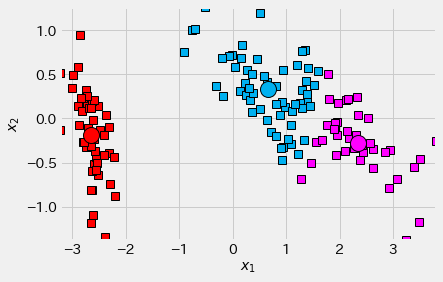

In [8]:
for ite in np.arange(10):

    # クラスター中心の出力
    print(f"反復{ite+1}、クラスター中心:\n{myModel.C}")
    
    # クラスターの更新
    myModel.updateCluster()
    
    # クラスターのプロット
    if X.shape[1] == 2:
        myModel.plotCluster(fName=f"../results/kmeans_results_{dataType}_{myModel.K}_{ite}.pdf")